### Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/New_Alteration_zones

/content/drive/MyDrive/New_Alteration_zones


In [4]:
!pip install contextily
!pip install pyrsgis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.3 MB/s 
     |████████████████████████████████| 19.3 MB 6.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from pyrsgis import raster
from pyrsgis.convert import array_to_table
from pyrsgis.ml import imageChipsFromArray
import random
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential

### Training the model using MLP

In [6]:
%cd train_Landsat9/MLP_Landsat9

/content/drive/MyDrive/New_Alteration_zones/train_Landsat9/MLP_Landsat9


In [7]:
from numpy import load
train_x = load('train_x.npy')
test_x = load('train_y.npy')
train_y = load('test_x.npy')
test_y = load('test_y.npy')
train_y = pd.get_dummies(train_y, drop_first=False).values
test_y = pd.get_dummies(test_y, drop_first=False).values

In [8]:
def plot_metric(history, metric):    #For plotting any graph relating to any model
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

def plot_avg_AUC_ROC(y_pred, test_y, n_classes, label_names, figsize=(6.4, 4.8), average="macro"):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  #y_pred = model.predict(test_x, batch_size=64, verbose=1)
  y_test_dummies = pd.get_dummies(test_y, drop_first=False).values
  
  for i in range(n_classes):
    #fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i].astype(int) ,y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

      # roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')
  for i in range(n_classes):
      ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for {}'.format('{0:.2f}'.format(roc_auc[i]), label_names[i]))
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

def roc(model, test_x, test_y, n_classes):
  fpr = {}
  tpr = {}
  roc_auc = {}

  y_pred = model.predict(test_x, batch_size=64, verbose=1)
  y_test_dummies = pd.get_dummies(test_y, drop_first=False).values
  prediction = pd.get_dummies(y_pred.argmax(axis = 1),drop_first=False).values
  print(n_classes)
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  return roc_auc



In [9]:
############## ORiginal Model Code ###################
def MLP_model(optimiser_type, experimental_runs, train_x, train_y, test_x, test_y):
  best_accuracy = 0
  best_model = tf.keras.models.Sequential()
  best_history = None

  columns = ['Accuracy', 'precision', 'recall', 'F1_score', "AUC_0", "AUC_1", "AUC_2", "Aggregate_AUC"]
  df = pd.DataFrame(columns = columns)

  for i in range(experimental_runs):
    #Model_name = "CNN_RMSPROP"

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(7, activation='selu', input_shape=(train_x.shape[1], )))
    model.add(tf.keras.layers.Dense(5, activation='selu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    print(model.summary())

    model.compile(loss='categorical_crossentropy', optimizer=optimiser_type, metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs = 80, validation_data = (test_x, test_y))

    sum_y_pred = 0
    # predict for the test dataset
    yTestPredicted = model.predict(test_x)
    sum_y_pred = sum_y_pred + yTestPredicted
    # calculate and display error metrics
    yTestPredicted_ = yTestPredicted.argmax(axis=1)

    n_classes = 3
    test_y_dummies = test_y.argmax(axis = 1)
    Accuracy = accuracy_score(test_y_dummies, yTestPredicted_)
    cMatrix = confusion_matrix(test_y_dummies, yTestPredicted_)
    pScore = precision_score(test_y_dummies, yTestPredicted_, average='macro')
    rScore = recall_score(test_y_dummies, yTestPredicted_, average='macro')
    fscore = f1_score(test_y_dummies, yTestPredicted_, average='macro')

    #This function calculates all the evaluation metrics for every iteration
    roc_auc = roc(model, test_x, test_y_dummies, n_classes)
    result_array = [Accuracy, pScore, rScore, fscore]


    sum_of_roc_scores = 0
    for i in range(n_classes):
      result_array.append(roc_auc[i])
      sum_of_roc_scores = sum_of_roc_scores + roc_auc[i]

    aggregate_roc_score = sum_of_roc_scores/n_classes
    result_array.append(aggregate_roc_score)

    print("Confusion matrix:\n", cMatrix)
    print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))
    
    if best_accuracy < Accuracy:
      best_model = model
      best_accuracy = Accuracy
      best_history = history

    print(result_array)
    result_dict = {'Accuracy': Accuracy, 'precision': pScore, 'recall' : rScore, 'F1_score': fscore, "AUC_0": result_array[4]
                   , "AUC_1": result_array[5], "AUC_2": result_array[6], "Aggregate_AUC": result_array[7]}
    df = df.append(result_dict, ignore_index = True)
  print(df)
  return best_model, best_history, sum_y_pred/experimental_runs, df

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 5)                 40        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/80
33/33 [==============================] - 1s 10ms/step - loss: 1.1363 - accuracy: 0.2971 - val_loss: 1.1176 - val_accuracy: 0.3533
Epoch 2/80
33/33 [==============================] - 0s 3ms/step - loss: 1.1116 - accuracy: 0.3210 - val_loss: 1.1022 - val_accuracy: 0.3222
Epoch 3/80
33/33 [================

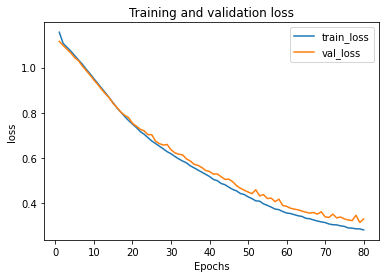

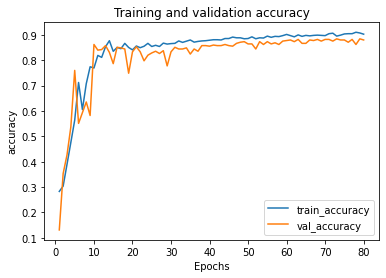

[[4.6263859e-02 4.8990872e-02 4.7452664e-03]
 [9.4615779e-04 9.0840720e-02 8.2131308e-03]
 [8.1326596e-02 1.5675958e-02 2.9974501e-03]
 ...
 [6.0714344e-03 2.0742193e-02 7.3186383e-02]
 [4.5632558e-05 5.4841959e-03 9.4470166e-02]
 [2.9340828e-02 2.6167195e-02 4.4491984e-02]]


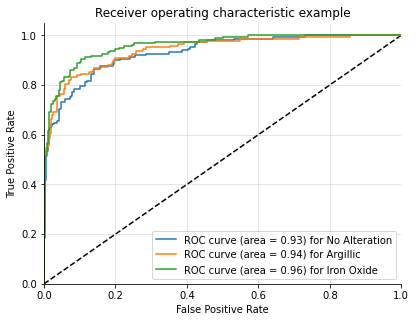

In [10]:
Model_name = 'MLP_RMSPROP'
NAME = 'Landsat9_DATA'
optimiser_type = 'rmsprop'
experimental_runs = 10

best_model, best_history, avg_y_pred, df = MLP_model(optimiser_type, experimental_runs, train_x, train_y, test_x, test_y)
df.to_csv('Results_{}_{}.csv'.format(NAME, Model_name))
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))
plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
label_names = ["No Alteration", "Argillic" , "Iron Oxide"]
print(avg_y_pred)
test_y_dummies = test_y.argmax(axis = 1)
plot_avg_AUC_ROC(avg_y_pred, test_y_dummies, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 7)                 56        
                                                                 
 dense_31 (Dense)            (None, 5)                 40        
                                                                 
 dense_32 (Dense)            (None, 3)                 18        
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/80
33/33 [==============================] - 1s 10ms/step - loss: 1.1283 - accuracy: 0.3314 - val_loss: 1.0927 - val_accuracy: 0.3800
Epoch 2/80
33/33 [==============================] - 0s 3ms/step - loss: 1.0858 - accuracy: 0.3152 - val_loss: 1.0751 - val_accuracy: 0.2200
Epoch 3/80
33/33 [===============

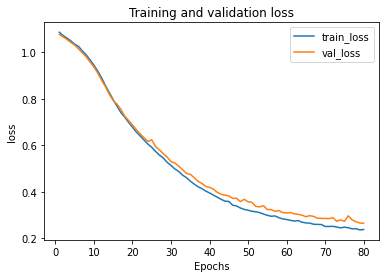

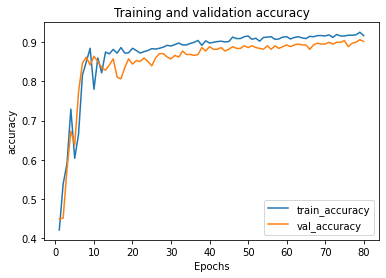

[[2.17246544e-02 7.77595192e-02 5.15827909e-04]
 [1.63315111e-04 9.97924060e-02 4.42814053e-05]
 [9.01643783e-02 4.06660698e-03 5.76901250e-03]
 ...
 [9.91544779e-03 5.60324313e-03 8.44813138e-02]
 [1.18321215e-04 1.14623189e-03 9.87354442e-02]
 [3.47294398e-02 3.18925572e-03 6.20813146e-02]]


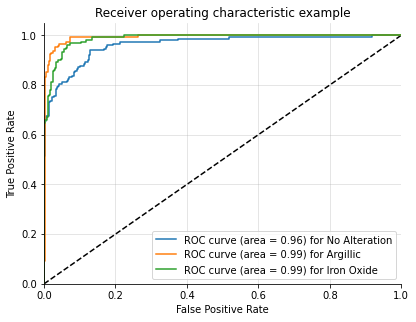

In [11]:
Model_name = 'MLP_ADAM'
NAME = 'Landsat9_DATA'
optimiser_type = 'adam'
experimental_runs = 10

best_model, best_history, avg_y_pred, df = MLP_model(optimiser_type, experimental_runs, train_x, train_y, test_x, test_y)
df.to_csv('Results_{}_{}.csv'.format(NAME, Model_name))
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))
plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
label_names = ["No Alteration", "Argillic" , "Iron Oxide"]
print(avg_y_pred)
test_y_dummies = test_y.argmax(axis = 1)
plot_avg_AUC_ROC(avg_y_pred, test_y_dummies, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 7)                 56        
                                                                 
 dense_61 (Dense)            (None, 5)                 40        
                                                                 
 dense_62 (Dense)            (None, 3)                 18        
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/80
33/33 [==============================] - 1s 9ms/step - loss: 1.0990 - accuracy: 0.3276 - val_loss: 1.0926 - val_accuracy: 0.3378
Epoch 2/80
33/33 [==============================] - 0s 4ms/step - loss: 1.0941 - accuracy: 0.3467 - val_loss: 1.0891 - val_accuracy: 0.3333
Epoch 3/80
33/33 [================

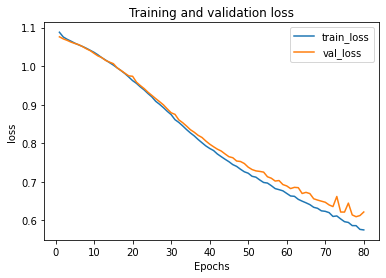

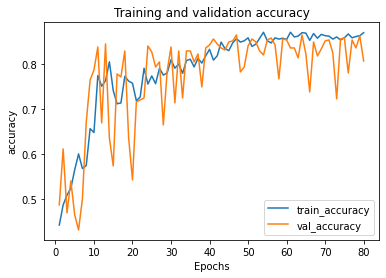

[[0.04869618 0.02860203 0.02270177]
 [0.0032593  0.04441226 0.05232845]
 [0.07739821 0.01269505 0.00990673]
 ...
 [0.01886055 0.03848315 0.04265628]
 [0.00173533 0.03881037 0.05945429]
 [0.04649197 0.02719045 0.02631758]]


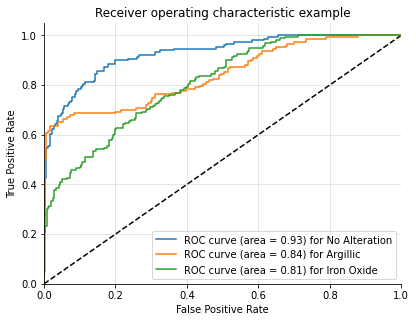

In [12]:
Model_name = 'MLP_SGD'
NAME = 'Landsat9_DATA'
optimiser_type = 'sgd'
experimental_runs = 10

best_model, best_history, avg_y_pred, df = MLP_model(optimiser_type, experimental_runs, train_x, train_y, test_x, test_y)
df.to_csv('Results_{}_{}.csv'.format(NAME, Model_name))
best_model.save('Best_model_{}_{}'.format(NAME, Model_name))
plot_metric(best_history, "loss")
print("")
plot_metric(best_history, "accuracy")
# plot_AUC_ROC(best_model, test_x, test_y, 3, label_names)
# print("")
label_names = ["No Alteration", "Argillic" , "Iron Oxide"]
print(avg_y_pred)
test_y_dummies = test_y.argmax(axis = 1)
plot_avg_AUC_ROC(avg_y_pred, test_y_dummies, 3, label_names)
print("")
avg_y_pred = avg_y_pred.argmax(axis=-1)

### Training the model using SVM

In [13]:
from numpy import load
train_x = load('train_x.npy')
test_x = load('train_y.npy')
train_y = load('test_x.npy')
test_y = load('test_y.npy')

In [23]:
def roc(model, test_x, test_y, n_classes):
  fpr = {}
  tpr = {}
  roc_auc = {}

  y_pred = model.predict(test_x)
  y_test_dummies = pd.get_dummies(test_y, drop_first=False).values
  prediction = pd.get_dummies(y_pred).values
  print(n_classes)
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


  return roc_auc

In [15]:
def plot_avg_AUC_ROC(y_pred, test_y, n_classes, label_names, figsize=(6.4, 4.8), average="macro"):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  #y_pred = model.predict(test_x, batch_size=64, verbose=1)
  y_test_dummies = pd.get_dummies(test_y, drop_first=False).values
  
  for i in range(n_classes):
    #fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i].astype(int) ,y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

      # roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')
  for i in range(n_classes):
      ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for {}'.format('{0:.2f}'.format(roc_auc[i]), label_names[i]))
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(train_x, train_y)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


grid_predictions = grid.predict(test_x)
  
# print classification report
print(classification_report(test_y, grid_predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.600 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.576 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.567 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.557 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.552 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.343 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.343 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.338 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.338 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.338 total time=   0.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.343 total time=   0.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

Confusion matrix:
 [[131   4  13]
 [  2 140   1]
 [  8   0 151]]

P-Score: 0.939, R-Score: 0.938, F-Score: 0.938
3
Confusion matrix:
 [[131   4  13]
 [  2 140   1]
 [  8   0 151]]

P-Score: 0.939, R-Score: 0.938, F-Score: 0.938
   Accuracy  precision    recall  F1_score     AUC_0     AUC_1     AUC_2  \
0  0.937778   0.938817  0.937947  0.938094  0.926011  0.982996  0.950788   

   Aggregate_AUC  
0       0.953265  


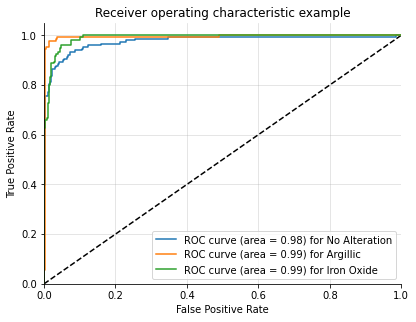

In [38]:
n_classes = 3
NAME = "Landsat9_DATA"
Model_name = "SVM"
columns = ['Accuracy', 'precision', 'recall', 'F1_score', "AUC_0", "AUC_1", "AUC_2", "Aggregate_AUC"]
df = pd.DataFrame(columns = columns)
from sklearn.metrics import roc_curve, roc_auc_score
model = SVC(C=100, kernel='rbf', gamma=1, probability=True)
model.fit(train_x, train_y)

yTestPredicted = model.predict(test_x)
n_classes = 3
Accuracy = accuracy_score(test_y, yTestPredicted)
cMatrix = confusion_matrix(test_y, yTestPredicted)
pScore = precision_score(test_y, yTestPredicted, average='macro')
rScore = recall_score(test_y, yTestPredicted, average='macro')
fscore = f1_score(test_y, yTestPredicted, average='macro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

#This function calculates all the evaluation metrics for every iteration
roc_auc = roc(model, test_x, test_y, n_classes)

sum_of_roc_scores = 0
for i in range(n_classes):
  sum_of_roc_scores = sum_of_roc_scores + roc_auc[i]

aggregate_roc_score = sum_of_roc_scores/n_classes


print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

result_dict = {'Accuracy': Accuracy, 'precision': pScore, 'recall' : rScore, 'F1_score': fscore, "AUC_0": roc_auc[0]
                   , "AUC_1": roc_auc[1], "AUC_2": roc_auc[2], "Aggregate_AUC": aggregate_roc_score}
df = df.append(result_dict, ignore_index = True)
print(df)
df.to_csv('Results_{}_{}.csv'.format(NAME, Model_name))

label_names = ["No Alteration", "Argillic" , "Iron Oxide"]
y_pred = model.predict_proba(test_x)
plot_avg_AUC_ROC(y_pred, test_y, 3, label_names)